In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Opción para ver todas las columnas del dataset en el notebook
pd.set_option('display.max_columns', 50)

In [3]:
data = "data/bank-additional-full.csv"
df = pd.read_csv(data, sep=";")

In [4]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Práctico 04: Aprendizaje Supervisado

Para finalizar nuestro modelo, aplicaremos estrategias de sampling para dividir entre train y test y haremos crossvalidation sobre train. Realizaremos pruebas con varios clasificadores y evaluaremos los resultados con múltiples métricas. Por último calcularemos el feature importance y obtendremos conclusiones.

## Objetivo del práctico

### Train-Validation-Test
(obtener del práctico anterior)
- División del dataset en train/validation/test
- Estratificación

In [5]:
# Reemplazamos la columna y (target) por 1 y 0
df.y = df.y.replace('yes', 1)
df.y = df.y.replace('no', 0)

In [6]:
#Eliminamos los outliers de Campaign:
q975_campaign=df.campaign.quantile(0.975)
df.drop(df[df.campaign >= q975_campaign].index, inplace = True)

In [7]:
#Diferenciamos los atributos del target
X = df.drop(columns='y')
y = df.y

In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)   #Dejamos un conjunto de test con el 20% de los casos 
#Dado que el dataset se encuentra desbalanceado (aprox. 11% del total de casos pertenece a la clase 1), empleamos el parámetro stratified en función del target (y)
#De este modo, la muestra seleccionada a partir de la división sería representativa para las dos clases

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp)

In [10]:
#Para hacer algunas pruebas sin hacer doble division
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, stratify=y)

### Preprocesamiento

- Tratamiento de valores nulos
- Estandarización
- Encoding de variables categóricas

In [11]:
class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

#### Pipeline genérico para pre-procesamiento

In [45]:
#Aplicamos las transformaciones previas a los conjuntos de Train y Validation

# variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
# variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome','month', 'day_of_week']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx','nr.employed','emp.var.rate','cons.price.idx']
variables_pca = ['pca1', 'pca2', 'pca3', 'pca4']

# Filtramos las variables que seleccionamos
X_te = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas] 
X_te = X_test[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler()), #Solamente activamos esta línea cuando el clasificador requiere escalado de variables numéricas (SVM, SGD)
                            ('pca', PCA(n_components=4))   #En los casos que usemos las componentes principales en lugar de las variables numéricas
                             ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                  ('imputer', SimpleImputer(strategy='most_frequent', missing_values='unknown')),     #Activamos en el caso que quisieramos imputar la categoría desconocido
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])


train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)
test = pipeline_completo.fit_transform(X_te)

### Definición de métricas

Definiremos las métricas a utilizar:
- Accuracy
- Precision
- Recall
- F1
- AUC
- PRAUC  

Además investigaremos como utilizar el classification report y confusion matrix. Adicionalmente, cómo usar crossvalidation.

Dado que el problema se encuetra desbalanceado, la Accuracy no es la medida adecuada para el análisis. Las métricas más adecuadas para el análisis comparativos de los modelos son: Precision, Recall, F1, AUC, PRAUC.

Explicación de las métricas utilizadas a un stakeholder no técnico.

El conjunto de datos con que contamos para el análisis presenta una mayor cantidad de casos pertenecientes al grupo de clientes que no contrataron el PF en la última campaña de marketing en relación a aquellos clientes que si lo contrataron, razón por la cual decimos que el dataset se encuentra desbalanceado. Esta situación implica que contamos con mayor información para caracterizar a quienes no contrarían el PF que aquella disponible para caracterizar al grupo de clientes que si contratarían el PF, es decir, aquellos que constituyen el objetivo para nosotros.

En este caso, para evaluar de manera comparativa una serie de modelos predictivos y poder juzgar cuál/es de ellos son los mejores tenemos que ser cuidadosos al momento de definir las métricas. No es recomendable confiar en métricas que se concentren únicamente en la cantidad de casos que están bien clasificados ya que se le estaría dando una mayor predominancia a las clasificaciones dentro de la clase mayoritaria (clientes que no contratan PF).

En cuanto a las métricas tenemos entonces: 
- La Precisión representa qué porcentaje de los clientes que nuestro modelo predice que van a convertir, efectivamente lo hacen.
- La Recall representa qué porcentaje de los clientes que convierten son captados correctamente por nuestro modelo predicitivo. 

Dado que nos interesa tanto la proporción de clientes que efectivamente convierten así como también la proporción de clientes que convierten bien identificados por el modelo, vamos a optar por una métrica que balancea estas dos cuestiones: la F1. Esta métrica es la media armónica de las dos anteriores, y sirve para poder evaluar comparativamente una serie de modelos contemplando los dos criterios mencionados.    

## Testeo con varios modelos

Realizaremos varios tests con diversos tipos de modelos, tanto aquellos de la librería scikit-learn, como otros que no pertencen a ella:
- Decision Tree
- SGD Classifier
- Logistic regression  
- SVM     
- Naive Bayes
- Random Forest
- XGBoost
- LightGBM

Usaremos crossvalidation y compararemos con validation y test.

Realizaremos también optimizaciones de hiperparámetros en busca de los mejores valores para las métricas, empleando tanto Grid Search como Randomized Search (en los casos en que la búsqueda se vuelva muy compleja).

## **Modelos Analizados**

#### **MODELO BASELINE**

El modelo estimado como baseline para el problema bajo análisis fue un Árbol de Decsisiones, que fue presentado en el Práctico 3 y se incluye abajo para tomar de referencia en la comparación con los nuevos modelos que se entrenarán.

In [11]:
#Pre-procesamiento sobre los conjuntos de Train y Test
variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]


pipeline_numerico = Pipeline([
                             ('select_numeric_columns', SelectColumnsTransformer(variables_numericas))     #Para este modelo no es necesario escalar las variables numéricas
                            ])

pipeline_categorico = Pipeline ([('imputer', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
                                   ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [15]:
dt_clf = DecisionTreeClassifier(random_state=0, criterion = 'gini', max_depth = 10, min_samples_leaf = 3, min_samples_split = 2, class_weight="balanced")
dt_clf.fit(train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, random_state=0)

In [16]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= dt_clf.predict(train)
y_val_pred=dt_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     22715
           1       0.40      0.71      0.51      2945

    accuracy                           0.85     25660
   macro avg       0.68      0.79      0.71     25660
weighted avg       0.89      0.85      0.86     25660

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      5679
           1       0.31      0.61      0.41       736

    accuracy                           0.80      6415
   macro avg       0.63      0.72      0.64      6415
weighted avg       0.87      0.80      0.83      6415



In [21]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, y_train_pred)}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, y_val_pred)}')

 ROC_AUC para datos de Train: 0.7875952742834271
 ROC_AUC para datos de Val: 0.7167193732439116


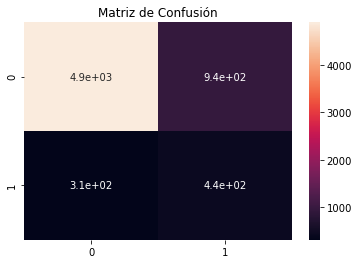

In [14]:
#Generamos la matriz de confusión para interpretar con mayor claridad los resultados
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,y_val_pred)

sns.heatmap(cm, annot=True)

plt.title("Matriz de Confusión")   
plt.show()

Cabe recordar que el objetivo es maximizar los valores que se encuentran en la diagonal princial (observaciones correctamente clasificadas para cada clase) y minimizar los valores de la diagonal secundaria (errores de clasificación de cada clase). 
En este caso puntual, el objetivo sería minimizar la cantidad de observaciones en el cuadrante inferior izquierdo, que representa clientes que contrataron el PF pero fueron clasificados por el modelo como que no lo contratarían, y el cuadrante superior derecho, que representa clientes que no contrataron el PF pero fueron clasificados por el modelo como que si lo contratarían.

#### **SGDClassifier**

En una primera instancia, entrenamos este modelo a partir de la misma selección de las variables originales, mientras que en una segunda instancia, con el objetivo de mejorar las métricas, se entrenó el modelo a partir de una selección de variables categóricas y las componentes principales que habían sido obtenidas a partir del análisis de componentes principales en el Práctico 2. Abajo se incluye el modelo que presentó las mejores métricas.

In [32]:
import warnings
warnings.filterwarnings("ignore")

parameters = {'model__loss':['hinge', 'log','squared_loss'], 'model__learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'], 
              'model__penalty': ['l2', 'l1', 'elasticnet'], 'model__eta0': [ 1e-6,0.001, 0.01, 0.1, 1, 10]}


pipeline = Pipeline([('model',SGDClassifier( random_state= 1, class_weight="balanced"))])
sgd_clf = GridSearchCV(pipeline, parameters, scoring=('f1'), cv = 5,return_train_score=True, refit='f1')

sgd_clf.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        SGDClassifier(class_weight='balanced',
                                                      random_state=1))]),
             param_grid={'model__eta0': [1e-06, 0.001, 0.01, 0.1, 1, 10],
                         'model__learning_rate': ['constant', 'optimal',
                                                  'invscaling', 'adaptive'],
                         'model__loss': ['hinge', 'log', 'squared_loss'],
                         'model__penalty': ['l2', 'l1', 'elasticnet']},
             refit='f1', return_train_score=True, scoring='f1')

In [43]:
display ('Best configuraton:')
display(sgd_clf.best_params_)

best_sgd_clf = sgd_clf.best_estimator_


'Best configuraton:'

{'model__eta0': 1,
 'model__learning_rate': 'invscaling',
 'model__loss': 'log',
 'model__penalty': 'l2'}

In [22]:
best_sgd_clf = SGDClassifier( random_state= 1, class_weight="balanced",
                            eta0 = 1,
                            learning_rate = 'invscaling',
                            loss = 'log',
                            penalty = 'l2')

best_sgd_clf.fit(train, y_train)

SGDClassifier(class_weight='balanced', eta0=1, learning_rate='invscaling',
              loss='log', random_state=1)

In [23]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= best_sgd_clf.predict(train)
y_val_pred=best_sgd_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     22715
           1       0.31      0.66      0.42      2945

    accuracy                           0.79     25660
   macro avg       0.63      0.74      0.65     25660
weighted avg       0.88      0.79      0.82     25660

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      5679
           1       0.30      0.67      0.42       736

    accuracy                           0.79      6415
   macro avg       0.63      0.74      0.64      6415
weighted avg       0.88      0.79      0.82      6415



Con los parámetros encontrados para SGD no se observan buenos valores de F1 sobre la clase positiva, pero advertimos que los resultados sobre train y val son similares, o sea que se ha evitado el overfitting.

In [24]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, y_train_pred)}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, y_val_pred)}')

 ROC_AUC para datos de Train: 0.7369245844368862
 ROC_AUC para datos de Val: 0.7366747819962179


#### **SVM**

In [25]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

search_params = {'C': [0.01,0.1,1,10],'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'] ,
                 'class_weight' : [None, 'balanced'], 'shrinking' : [True , False]}

svm_clf = GridSearchCV(svm.SVC(random_state = 42), search_params, cv=5, scoring='f1', n_jobs=-1)
svm_clf.fit(train_svm, y_train)

Mejores parámetros encontrados:

{'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf', 'shrinking': False}

In [26]:
#Corremos el SVC con los mejores parámetros encontrados:

svc_clf=SVC(random_state=0, class_weight="balanced", C = 1, kernel = 'rbf', shrinking = False)
svc_clf.fit(train, y_train)

SVC(C=1, class_weight='balanced', random_state=0, shrinking=False)

In [27]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= svc_clf.predict(train)
y_val_pred=svc_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

In [28]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, y_train_pred)}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, y_val_pred)}')

 ROC_AUC para datos de Train: 0.7650626516587209
 ROC_AUC para datos de Val: 0.7416421914834975


Con los parámetros encontrados para SVC no se observan buenos valores de F1 sobre la clase positiva, pero advertimos que los resultados sobre train y val son similares, o sea que se ha evitado el overfitting. Los resultados respecto a SGD son algo mejores.

#### **Random Forest**

In [36]:
search_params = {
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 6, 10, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf':[1,2,3]
}

forest_clf = RandomForestClassifier(random_state=42, class_weight = 'balanced')
cv_forest_clf = GridSearchCV(forest_clf, search_params, cv=5, scoring='f1', n_jobs=-1)
cv_forest_clf.fit(train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 10, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 500, 1000]},
             scoring='f1')

In [37]:
display ('Best configuraton:')
display(cv_forest_clf.best_params_)
best_forest_clf = cv_forest_clf.best_estimator_

'Best configuraton:'

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [29]:
best_forest_clf = RandomForestClassifier(random_state=42,
                          criterion = 'gini',
                          max_depth = None,
                           min_samples_leaf = 1,
                           min_samples_split = 3,
                           n_estimators = 1000,
                           class_weight="balanced"
                          )
best_forest_clf.fit(train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=3,
                       n_estimators=1000, random_state=42)

In [32]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= best_forest_clf.predict(train)
y_val_pred=best_forest_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     22715
           1       0.95      1.00      0.98      2945

    accuracy                           0.99     25660
   macro avg       0.98      1.00      0.99     25660
weighted avg       0.99      0.99      0.99     25660

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5679
           1       0.63      0.24      0.35       736

    accuracy                           0.90      6415
   macro avg       0.77      0.61      0.65      6415
weighted avg       0.88      0.90      0.88      6415



In [31]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, y_train_pred)}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, y_val_pred)}')

 ROC_AUC para datos de Train: 0.9964246941226022
 ROC_AUC para datos de Val: 0.6130380233813363


Lo que observamos en el caso de RF es que se está produciendo overfitting. Probablemente esto se deba a que el parámetro max_depth para el mejor modelo encontrado es **None**, con lo cual probamos ponerle un límite a esa profundidad para ver si mejora el ajuste en test:

In [33]:
best_forest_clf = RandomForestClassifier(random_state=42,
                          criterion = 'gini',
                          max_depth = 15,
                           min_samples_leaf = 1,
                           min_samples_split = 3,
                           n_estimators = 1000,
                           class_weight="balanced"
                          )
best_forest_clf.fit(train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=3, n_estimators=1000, random_state=42)

In [30]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= best_forest_clf.predict(train)
y_val_pred=best_forest_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     22715
           1       0.60      0.73      0.66      2945

    accuracy                           0.91     25660
   macro avg       0.78      0.83      0.81     25660
weighted avg       0.92      0.91      0.92     25660

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5679
           1       0.44      0.50      0.47       736

    accuracy                           0.87      6415
   macro avg       0.69      0.71      0.70      6415
weighted avg       0.88      0.87      0.87      6415



In [34]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, y_train_pred)}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, y_val_pred)}')

 ROC_AUC para datos de Train: 0.8327542849369559
 ROC_AUC para datos de Val: 0.7156010033150356


Ajustando el parámetro **max_depth**, logramos mitigar el problema de overfitting, y también mejora el F1 sobre la clase positiva en el conjunto de Test. Lo mismo se ve reflejado en el ROC_AUC

#### **Decision Tree**

In [35]:
import warnings
warnings.filterwarnings("ignore")

parameters = {'criterion':['gini', 'entropy'], 'max_depth':[None, 3, 5, 10, 20, 40], 'min_samples_split': [2,3,4], 'min_samples_leaf':[1,2,3,4]}
tree = DecisionTreeClassifier(random_state=0, class_weight = 'balanced')

cv_dt_clf = GridSearchCV(tree, parameters, scoring=('f1'), cv = 5,return_train_score=True, refit='f1')

cv_dt_clf.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 10, 20, 40],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4]},
             refit='f1', return_train_score=True, scoring='f1')

In [36]:
display ('Best configuraton:')
display(cv_dt_clf.best_params_)
best_dt_clf = cv_dt_clf.best_estimator_

'Best configuraton:'

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [35]:
best_dt_clf = DecisionTreeClassifier(random_state=0,
                          criterion = 'gini',
                          max_depth = 10,
                           min_samples_leaf = 4,
                           min_samples_split = 2,
                           class_weight="balanced"
                          )
best_dt_clf.fit(train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, random_state=0)

In [36]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= best_dt_clf.predict(train)
y_val_pred=best_dt_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     22715
           1       0.40      0.71      0.51      2945

    accuracy                           0.84     25660
   macro avg       0.68      0.79      0.71     25660
weighted avg       0.89      0.84      0.86     25660

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      5679
           1       0.31      0.62      0.41       736

    accuracy                           0.80      6415
   macro avg       0.63      0.72      0.65      6415
weighted avg       0.87      0.80      0.83      6415



In [37]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, y_train_pred)}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, y_val_pred)}')

 ROC_AUC para datos de Train: 0.7863909363348228
 ROC_AUC para datos de Val: 0.7213617628256659


No se observa una mejora significativa respecto al modelo Baseline de DT. Como es de esperarse, RandomForest arroja un mejor resultado que DT.

#### **Naive bayes**

Naive Bayes requiere que todos los atributos sean categóricos, con lo cual no es posible aplicar el PCA. Corremos un pipeline específico para correr este modelo:

In [81]:
variables_categoricas = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
variables_numericas = ['age', 'campaign', 'previous', 'cons.conf.idx', 'euribor3m']

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             # ('standard_scaler', StandardScaler()),
                             ("kbins_discretizer", KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="uniform")),   #strategy="uniform"
                             ('bins_cat', OneHotEncoder())
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                 #('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),      #podríamos no ponerlo, y que deje "desconocido" como una categoría más
                                 ('cat', OneHotEncoder())
                                 ])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                   ('cat', pipeline_categorico, variables_categoricas),
                                  ])

pipeline_modelo = Pipeline([('preprocess', pipeline_completo),
                            ('nb', ComplementNB())])

#The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.
#En el pre-procesamiento transformé todos los atributos en categóricos, porque es el requerimiento del tipo de modelo

In [83]:
#Solo Pre-procesamiento
train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [75]:
#Grilla de parámetros para optimización
params={'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.3, 1.5],
        'class_prior': [None, [0.9,0.1]],
        'fit_prior':[True, False],
        'norm':[True,False]
       }

nb=ComplementNB()

In [76]:
#Búsqueda de los mejores parámetros
cv_nb = GridSearchCV(nb, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_nb.fit(train, y_train)

In [66]:
cv_nb.best_params_

{'alpha': 0.1, 'class_prior': None, 'fit_prior': True, 'norm': True}

In [84]:
#Entrenamiento de la mejor versión encontrada del modelo
nb_best = ComplementNB(alpha=0.1, fit_prior=True, norm=True)
nb_best.fit(train, y_train)

ComplementNB(alpha=0.1, norm=True)

In [68]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, nb_best.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, nb_best.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     22715
           1       0.46      0.34      0.39      2945

    accuracy                           0.88     25660
   macro avg       0.69      0.64      0.66     25660
weighted avg       0.86      0.88      0.87     25660

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      5679
           1       0.46      0.36      0.40       736

    accuracy                           0.88      6415
   macro avg       0.69      0.65      0.67      6415
weighted avg       0.87      0.88      0.87      6415



En la mejor especificación encontrada para este tipo de modelos, y sobre el conjunto de validación, la F1 de la clase minoritaria es 0.40 y la F1 promedio entre las dos clases es 0.665. 

Dentro de la clase minoritaria tenemos que el 46% de los clientes que el modelo indica que contratarían el PF están identificados de manera correcta, y logra capturar al 36% de los clientes que efectivamente contrarían el PF.

#### **XGBoost**

In [75]:
import xgboost as xgb

In [114]:
#Optimización de hiperparámetros
#Grilla de parámetros
params={'objective':["binary:logistic","binary:hinge","binary:logitraw"],
        'learning_rate':[ 0.1,0.2,0.3],
        'max_depth':[2,4, 6, 7, 8, 10],
        'alpha':[2, 3, 5, 7],
        "n_estimators":[5, 7, 10]
       }
       
xg=xgb.XGBClassifier()

In [115]:
cv_xgb = GridSearchCV(xg, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_xgb.fit(train, y_train)

Mejores parámetros encontrados:

{'alpha': 5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 7,
 'objective': 'binary:hinge'}

In [38]:
#Corremos el modelo con los mejores parámetros encontrados:

xgb_best= xgb.XGBClassifier(seed=0, alpha= 5, learning_rate= 0.1, 
                               max_depth= 10,n_estimators=7, objective="binary:hinge"   
                                )   #el lambda por default es 1
xgb_best.fit(train, y_train)

/home/sseppi/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=7, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=0, reg_alpha=5,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, xgb_best.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xgb_best.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     22715
           1       0.43      0.52      0.47      2945

    accuracy                           0.87     25660
   macro avg       0.68      0.72      0.70     25660
weighted avg       0.88      0.87      0.87     25660

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5679
           1       0.46      0.52      0.49       736

    accuracy                           0.87      6415
   macro avg       0.70      0.72      0.71      6415
weighted avg       0.88      0.87      0.88      6415



In [39]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, xgb_best.predict(train))}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, xgb_best.predict(val))}')

 ROC_AUC para datos de Train: 0.7459556241864664
 ROC_AUC para datos de Val: 0.7427901086765123


#### **LGMB**

In [13]:
import lightgbm as lgb 

In [36]:
#Optimización de hiperparámetros
#Grilla de parámetros
params={'boosting_type':["gbdt","dart","goss","rf"],
        'learning_rate':[ 0.1,0.2,0.3,0.5,0.7,0.8,1],
        'max_depth':[1,2,4, 6, 7, 8, 10],
        'reg_alpha':[0, 2, 3, 5],
        "n_estimators":[5, 7, 10, 50, 100, 200, 500]
       }
lgb_clf = lgbm.LGBMClassifier(objective="binary", class_weight="balanced")

In [37]:
#Búsqueda de parámetros
cv_lgb = GridSearchCV(lgb_clf, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_lgb.fit(train, y_train)

In [40]:
#Entrenamiento de la mejor versión encontrada del modelo
lgb_best= lgbm.LGBMClassifier(objective="binary", class_weight="balanced", boosting_type= 'dart',
                     learning_rate= 0.2, max_depth= 8, n_estimators= 100, reg_alpha= 3 )
lgb_best.fit(train, y_train)

LGBMClassifier(boosting_type='dart', class_weight='balanced', learning_rate=0.2,
               max_depth=8, objective='binary', reg_alpha=3)

In [40]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, lgb_best.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, lgb_best.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     22715
           1       0.42      0.69      0.53      2945

    accuracy                           0.86     25660
   macro avg       0.69      0.79      0.72     25660
weighted avg       0.90      0.86      0.87     25660

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      5679
           1       0.30      0.65      0.42       736

    accuracy                           0.79      6415
   macro avg       0.63      0.73      0.64      6415
weighted avg       0.87      0.79      0.82      6415



In [41]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, lgb_best.predict(train))}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, lgb_best.predict(val))}')

 ROC_AUC para datos de Train: 0.7837856483247982
 ROC_AUC para datos de Val: 0.7451780539669415


#### Bagging

In [64]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
#bagging = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)

search_params = {
'base_estimator__n_neighbors' : [4,5,6,7, 10],
'base_estimator__weights': ['uniform', 'distance'],
'base_estimator__algorithm': ['ball_tree', 'kd_tree', 'brute'],
'base_estimator__p': [1,2],
'n_estimators' : [10, 50, 100, 200],
'max_samples' : [ 0.5, 0.6, 0.7,0.8],
'max_features': [0.5, 0.6,0.7,0.8,0.9]
}

bagging_clf = GridSearchCV(BaggingClassifier(KNeighborsClassifier(), random_state = 42), search_params, cv=5, scoring='f1', n_jobs=-1)
bagging_clf.fit(train, y_train)

Mejores parámetros encontrados para Bagging con KNN:

{'n_estimators': 10,
'max_samples': 0.8,
'max_features': 0.8,
'base_estimator__weights': 'distance',
'base_estimator__p': 2,
'base_estimator__n_neighbors': 5,
'base_estimator__algorithm': 'brute'}

In [42]:
best_bagging_clf = BaggingClassifier(KNeighborsClassifier(weights = 'distance',
                                                         p = 2,
                                                         n_neighbors = 5,
                                                         algorithm = 'brute'),
                                     random_state = 42,
                                    n_estimators = 10,
                                    max_samples = 0.8,
                                    max_features = 0.8)

best_bagging_clf.fit(train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='brute',
                                                      weights='distance'),
                  max_features=0.8, max_samples=0.8, random_state=42)

In [16]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, best_bagging_clf.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, best_bagging_clf.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22715
           1       0.98      0.81      0.89      2945

    accuracy                           0.98     25660
   macro avg       0.98      0.90      0.94     25660
weighted avg       0.98      0.98      0.97     25660

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5679
           1       0.56      0.20      0.29       736

    accuracy                           0.89      6415
   macro avg       0.73      0.59      0.62      6415
weighted avg       0.86      0.89      0.87      6415



In [43]:
#Computamos el ROC_AUC para Train y Val

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, best_bagging_clf.predict(train))}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, best_bagging_clf.predict(val))}')

 ROC_AUC para datos de Train: 0.9092276144907723
 ROC_AUC para datos de Val: 0.6006467142485281


### Conclusión Modelos

Si bien no fue posible superar un F1 de 0.5 en la clase positiva, y un F1 promedio de las clases de 0.71, con los modelos entrenados, podríamos concluir que los mejores resultados fueron encontrados con el modelo XGBoost seguido de Random Forest.

### Feature importance y explainability

#### Obtener los nombres de las variables

In [26]:
# Si realizamos one hot encoding, vamos a tener el problema de que se incrementan el numero de features y necesitamos la nueva lista.
numeric_features = variables_pca
cat_features = pipeline_modelo_dt.named_steps['preprocess'].transformers_[1][1][2].get_feature_names(variables_categoricas)

In [28]:
onehot_columns = np.array(cat_features)
numeric_features_list = np.array(numeric_features)
numeric_features_list = np.append(numeric_features_list, onehot_columns)

#### Decision Tree

In [43]:
#Corremos el pipeline con los parámetros del mejor modelo econtrado:

pipeline_modelo_dt = Pipeline([('preprocess', pipeline_completo),
                            ('dt', best_dt_clf)])
pipeline_modelo_dt.fit(X_t, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x7f3fe27315e0>),
                                                                  ('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  ['age', 'campaign',
                                                   'previous', 'euribor3m',
                                                   'cons.conf.idx',
                                                   'nr.employed',
                                                   'emp.var.rate',
     

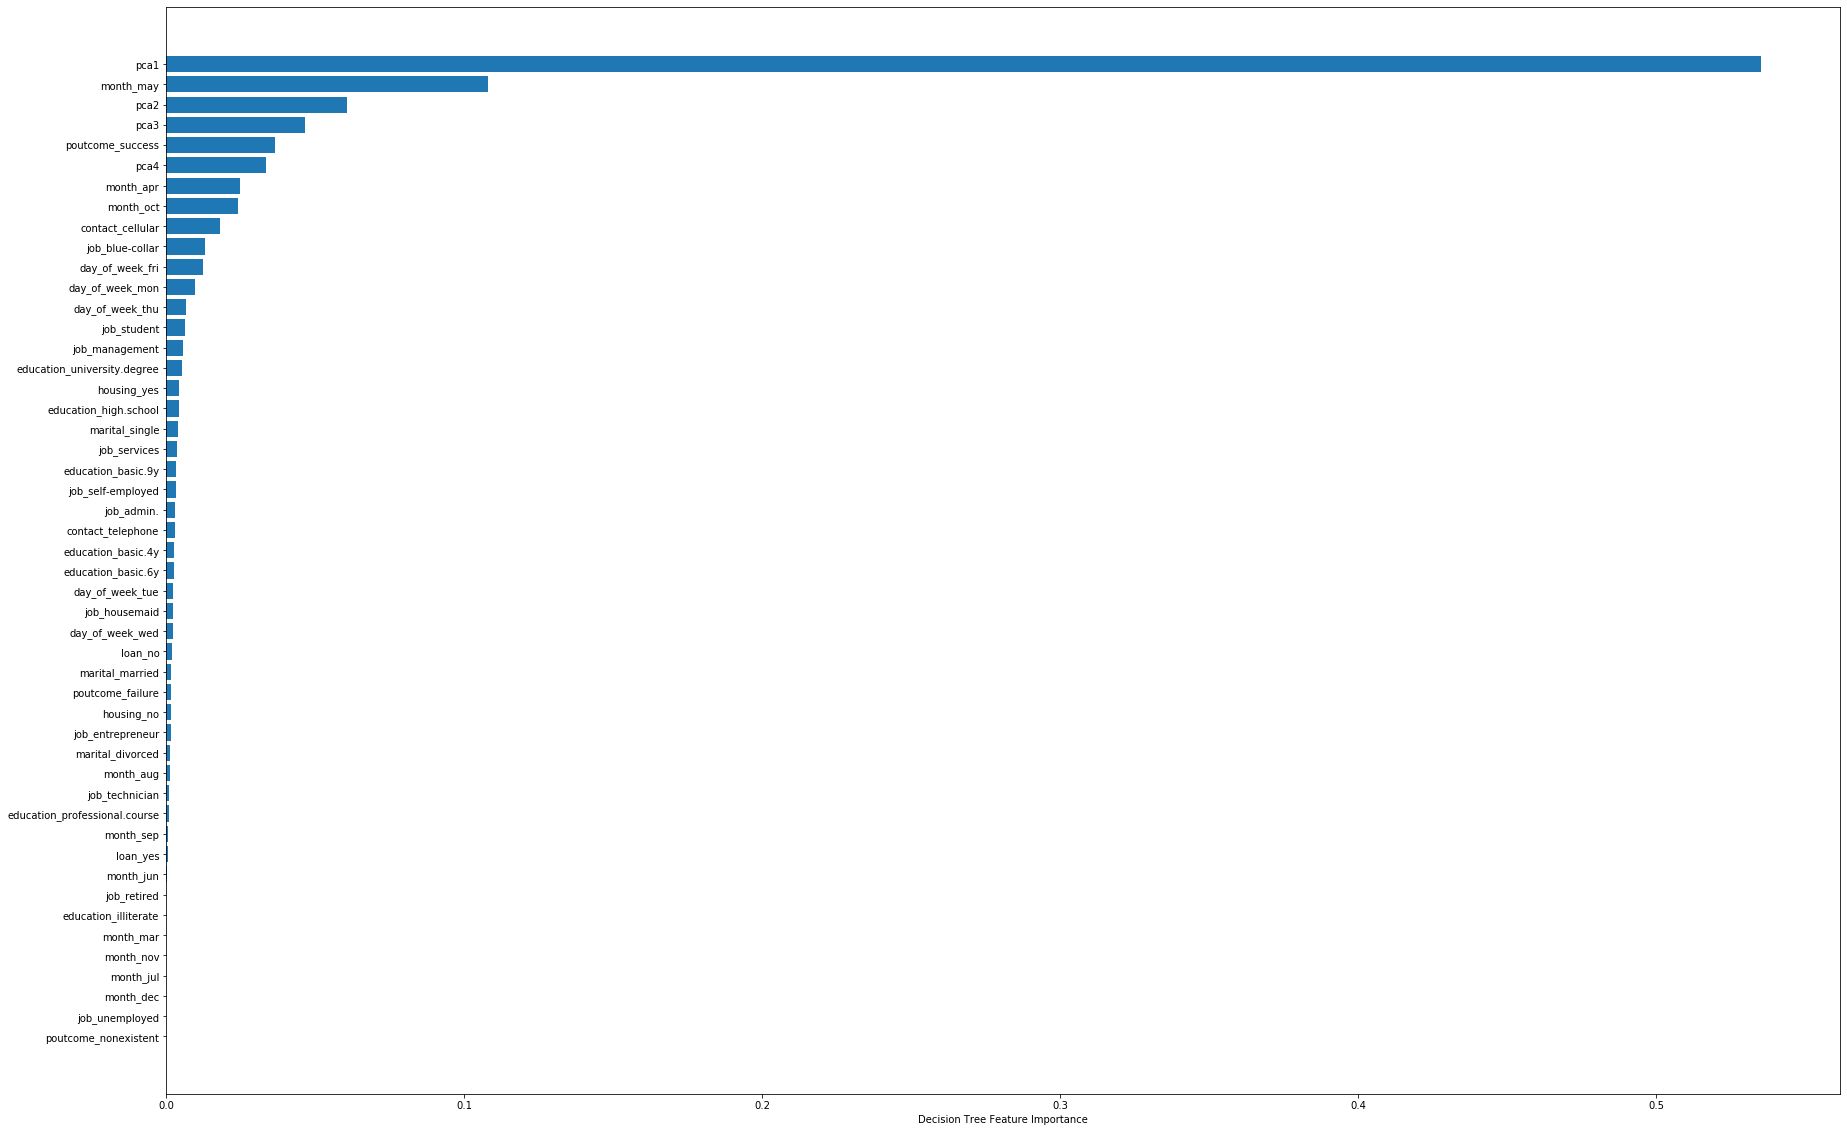

In [45]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_dt[1].feature_importances_.argsort()
plt.figure(figsize = (30,20))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_dt[1].feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

#### Random Forest

In [50]:
#Corremos el pipeline con los parámetros del mejor modelo econtrado:

pipeline_modelo_rf = Pipeline([('preprocess', pipeline_completo),
                            ('rf', best_forest_clf)])
pipeline_modelo_dt.fit(X_t, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x7f3fe27315e0>),
                                                                  ('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  ['age', 'campaign',
                                                   'previous', 'euribor3m',
                                                   'cons.conf.idx',
                                                   'nr.employed',
                                                   'emp.var.rate',
     

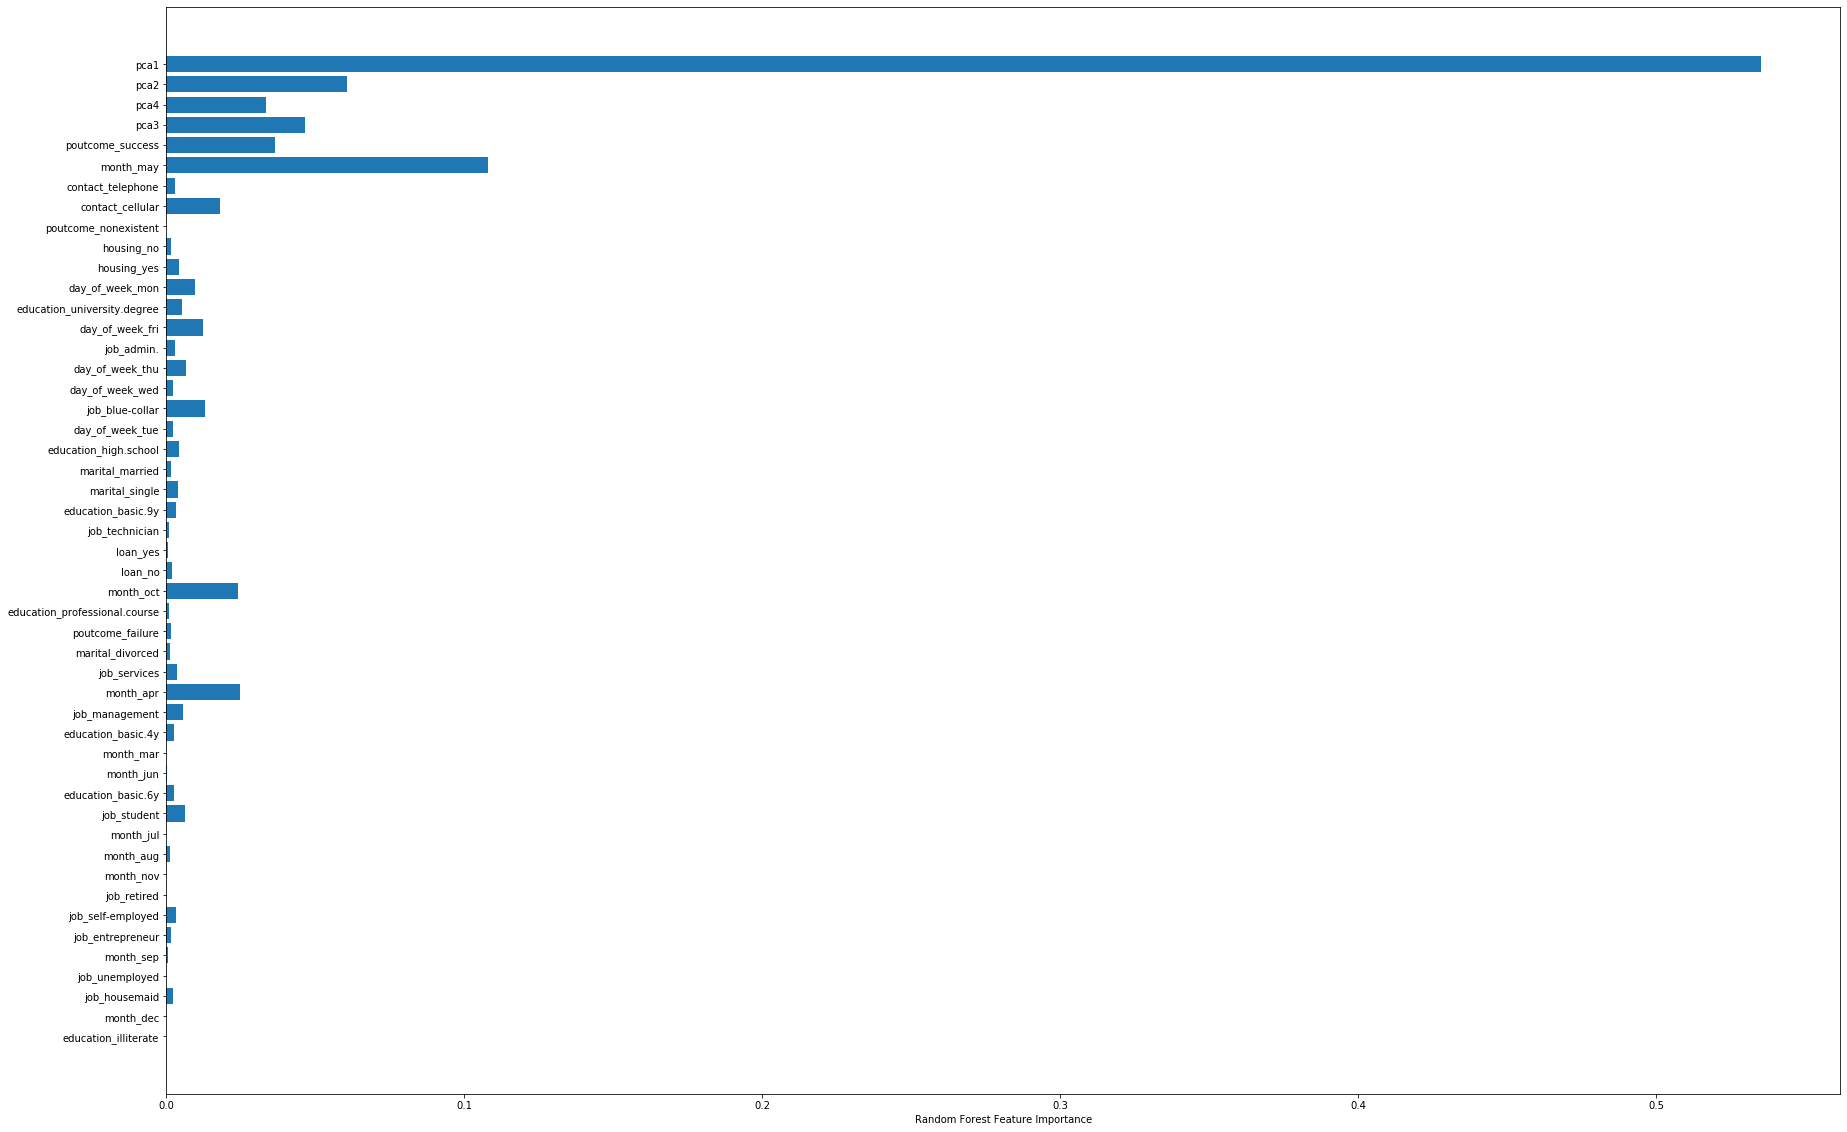

In [52]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_rf[1].feature_importances_.argsort()
plt.figure(figsize = (30,20))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_dt[1].feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

#### SGD

In [54]:
#Corremos el pipeline con los parámetros del mejor modelo econtrado:

pipeline_modelo_sgd = Pipeline([('preprocess', pipeline_completo),
                            ('rf', best_sgd_clf)])
pipeline_modelo_sgd.fit(X_t, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x7f3fe27315e0>),
                                                                  ('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  ['age', 'campaign',
                                                   'previous', 'euribor3m',
                                                   'cons.conf.idx',
                                                   'nr.employed',
                                                   'emp.var.rate',
     

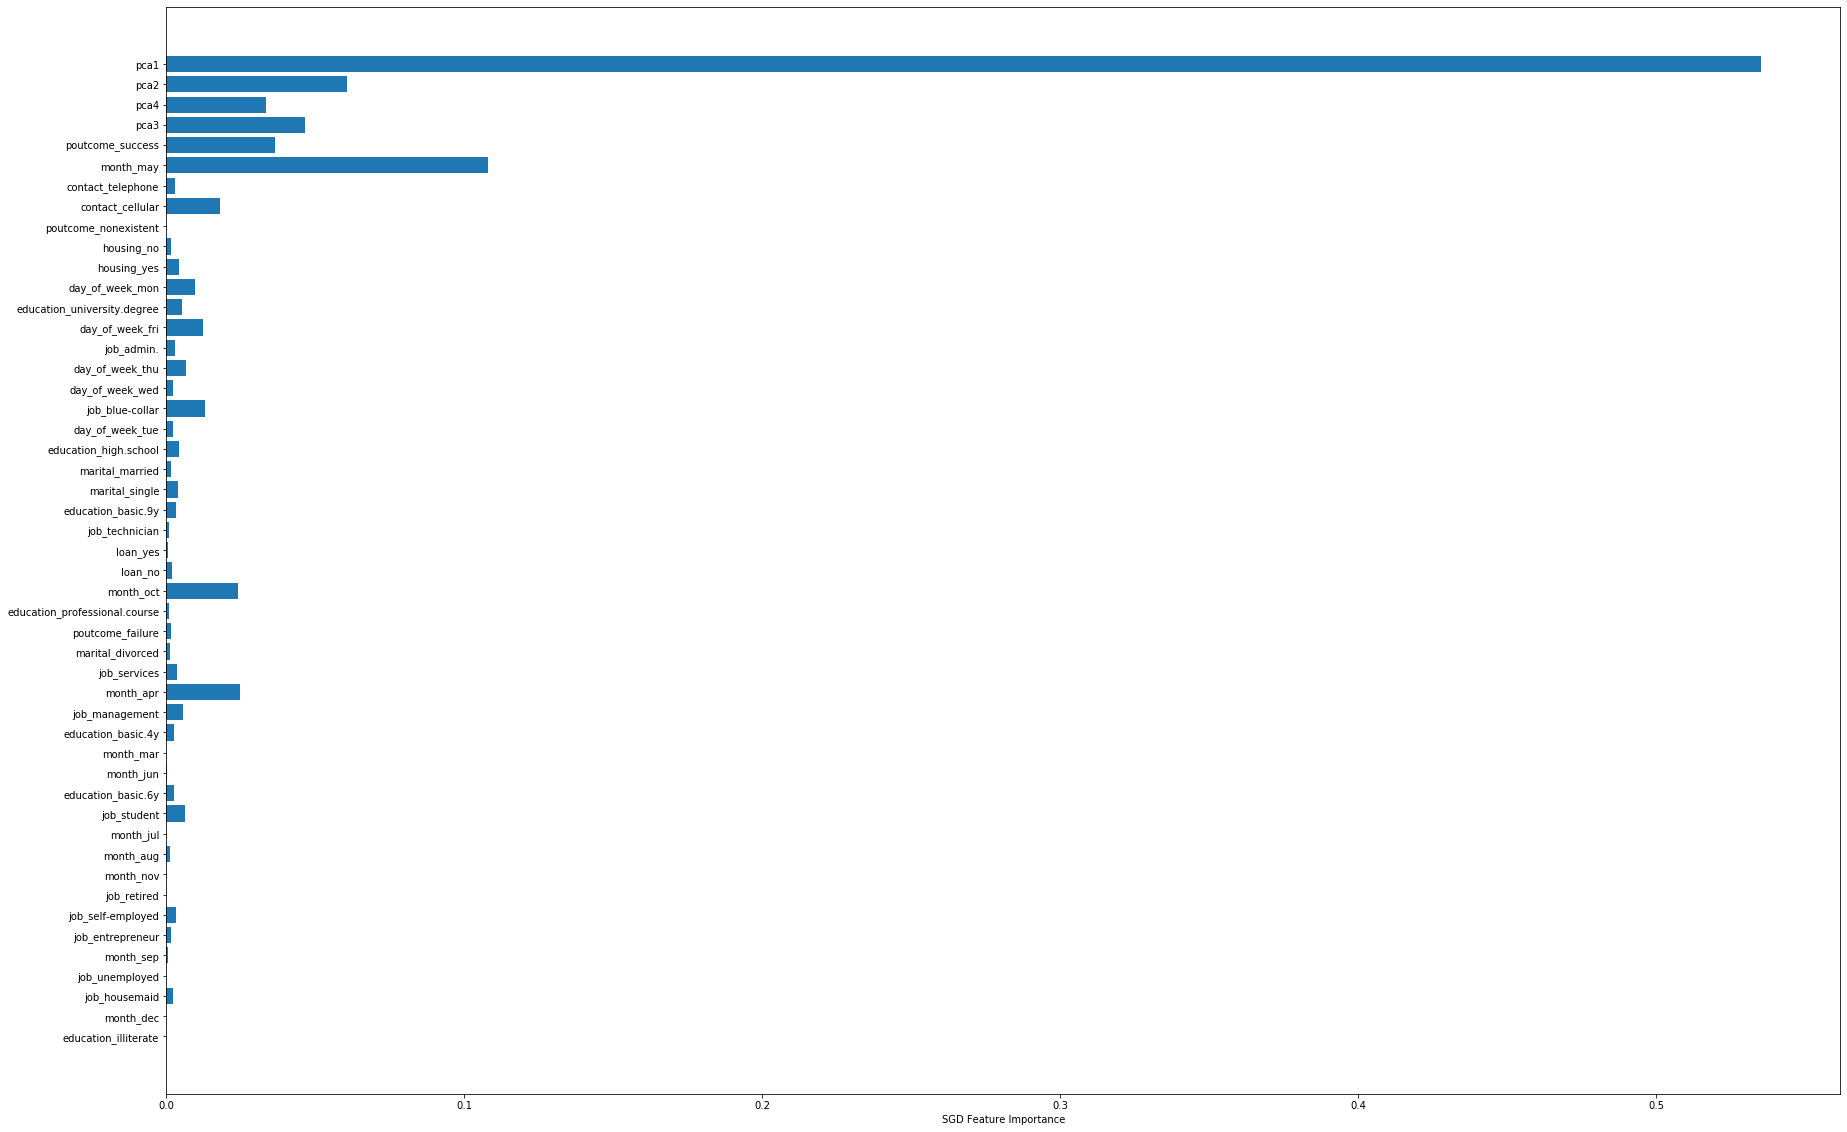

In [56]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_rf[1].feature_importances_.argsort()
plt.figure(figsize = (30,20))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_dt[1].feature_importances_[sorted_idx])
plt.xlabel("SGD Feature Importance")
plt.show()

#### Light GBM

In [58]:
#Corremos el pipeline con los parámetros del mejor modelo econtrado:

pipeline_modelo_gbm = Pipeline([('preprocess', pipeline_completo),
                            ('gmb', lgb_best)])
pipeline_modelo_gbm.fit(X_t, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x7f3fe27315e0>),
                                                                  ('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  ['age', 'campaign',
                                                   'previous', 'euribor3m',
                                                   'cons.conf.idx',
                                                   'nr.employed',
                                                   'emp.var.rate',
     

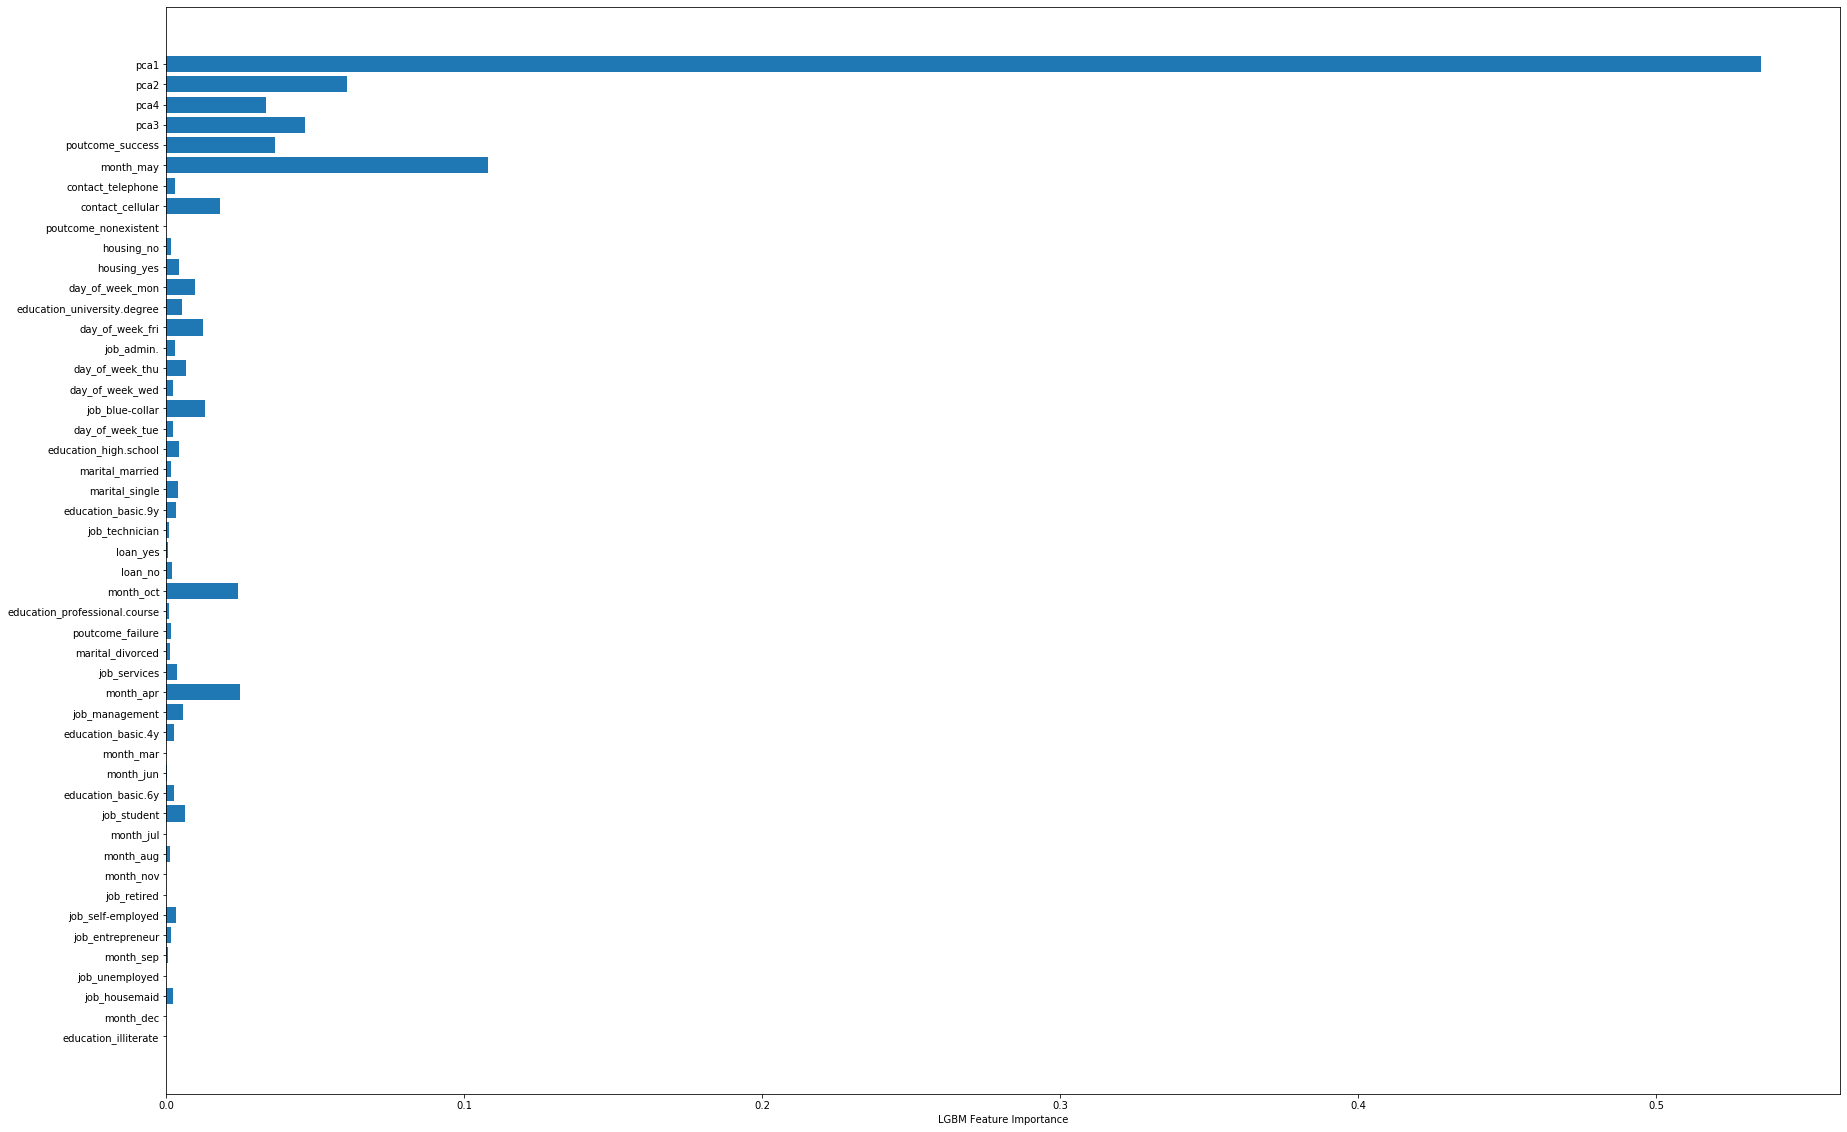

In [67]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_rf[1].feature_importances_.argsort()
plt.figure(figsize = (30,20))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_dt[1].feature_importances_[sorted_idx])
plt.xlabel("LGBM Feature Importance")
plt.show()

#### SVC

In [70]:
svc_clf=SVC(random_state=0, class_weight="balanced", C = 1, kernel = 'rbf', shrinking = False)

In [92]:
#Corremos el pipeline con los parámetros del mejor modelo econtrado:

pipeline_modelo_svc = Pipeline([('preprocess', pipeline_completo),
                            ('rf', svc_clf)])
pipeline_modelo_svc.fit(X_t, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x7f3fb19d2c10>),
                                                                  ('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  ['age', 'campaign',
                                                   'previous', 'euribor3m',
                                                   'cons.conf.idx',
                                                   'nr.employed',
                                                   'emp.var.rate',
     

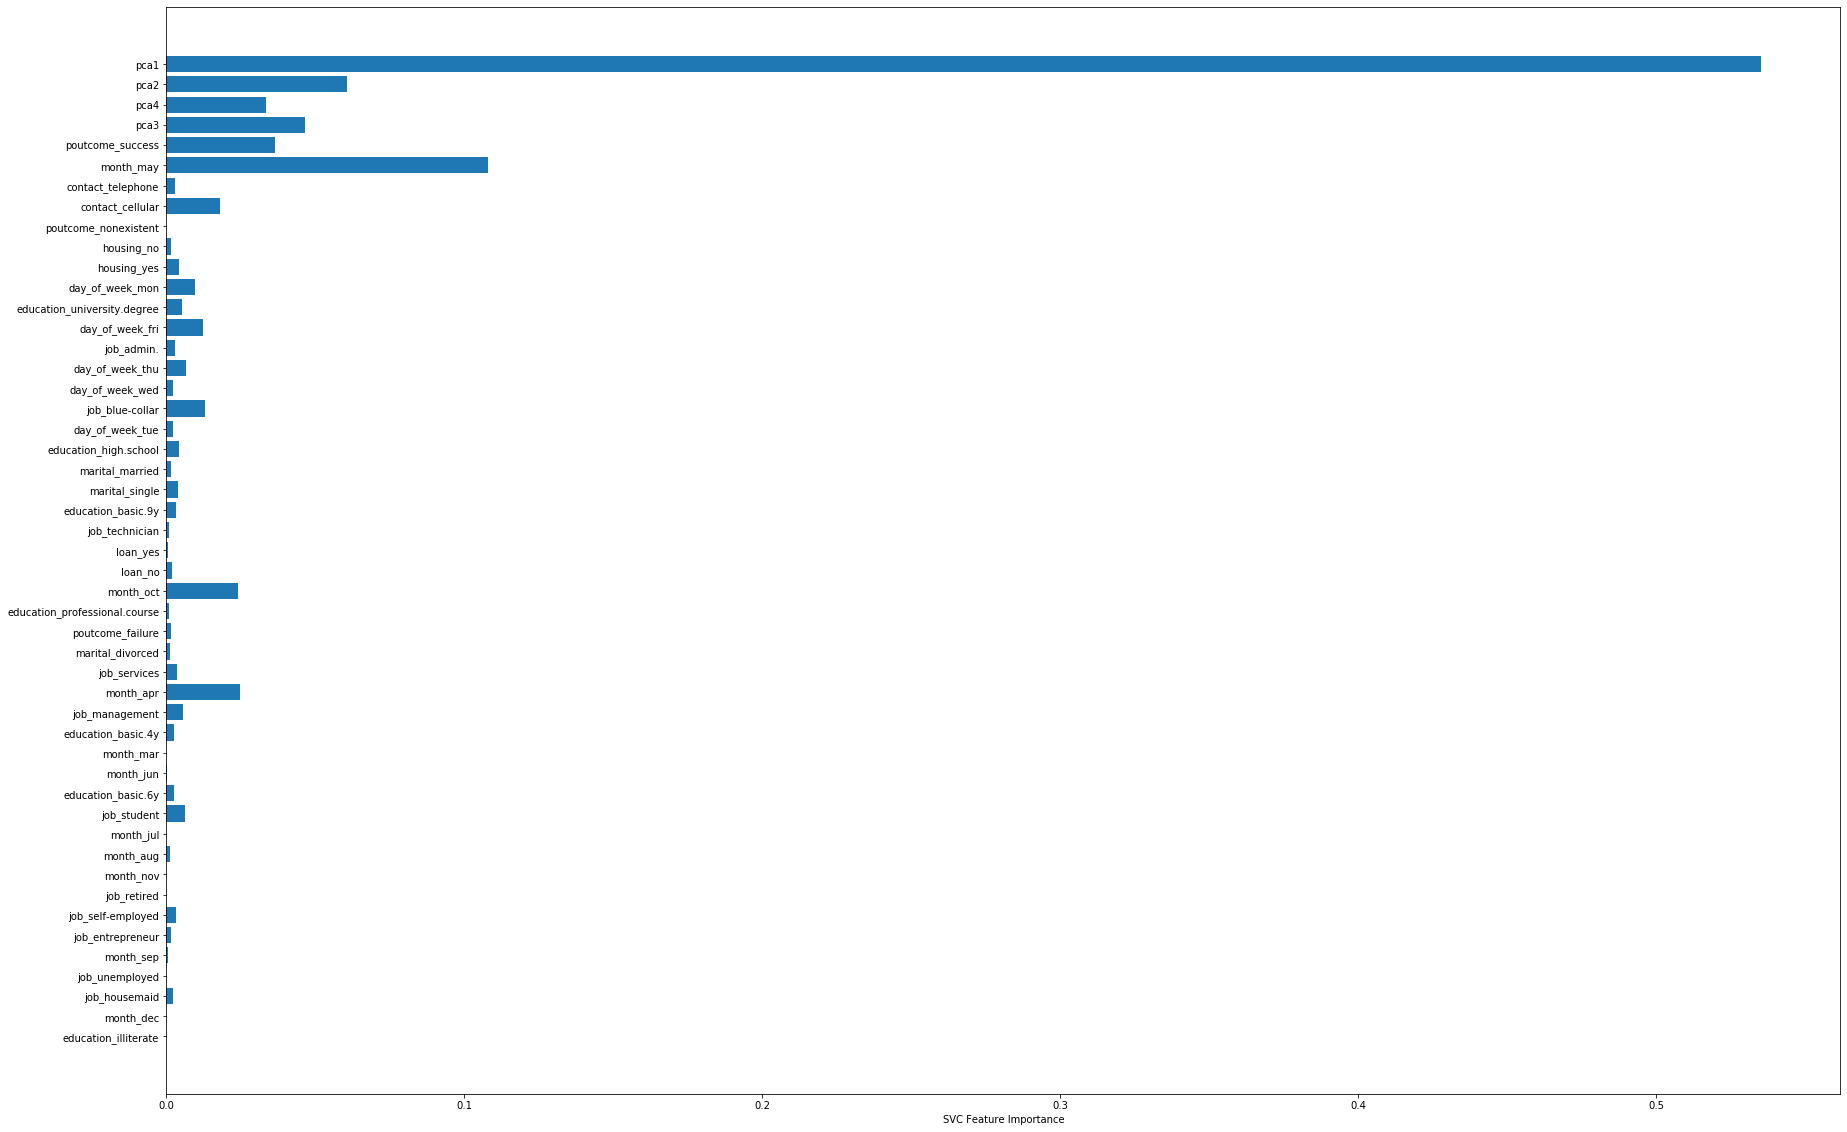

In [93]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_rf[1].feature_importances_.argsort()
plt.figure(figsize = (30,20))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_dt[1].feature_importances_[sorted_idx])
plt.xlabel("SVC Feature Importance")
plt.show()

#### Naive Bayes

In [86]:
pipeline_modelo_nb = Pipeline([('preprocess', pipeline_completo),
                            ('nb', nb_best)])
pipeline_modelo_nb.fit(X_t, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x7f3fb2118b80>),
                                                                  ('kbins_discretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=4,
                                                                                    strategy='uniform')),
                                                                  ('bins_cat',
                                                                   OneHotEncoder())]),
                                                  ['age', 'campaign',
                                                   'previous', 

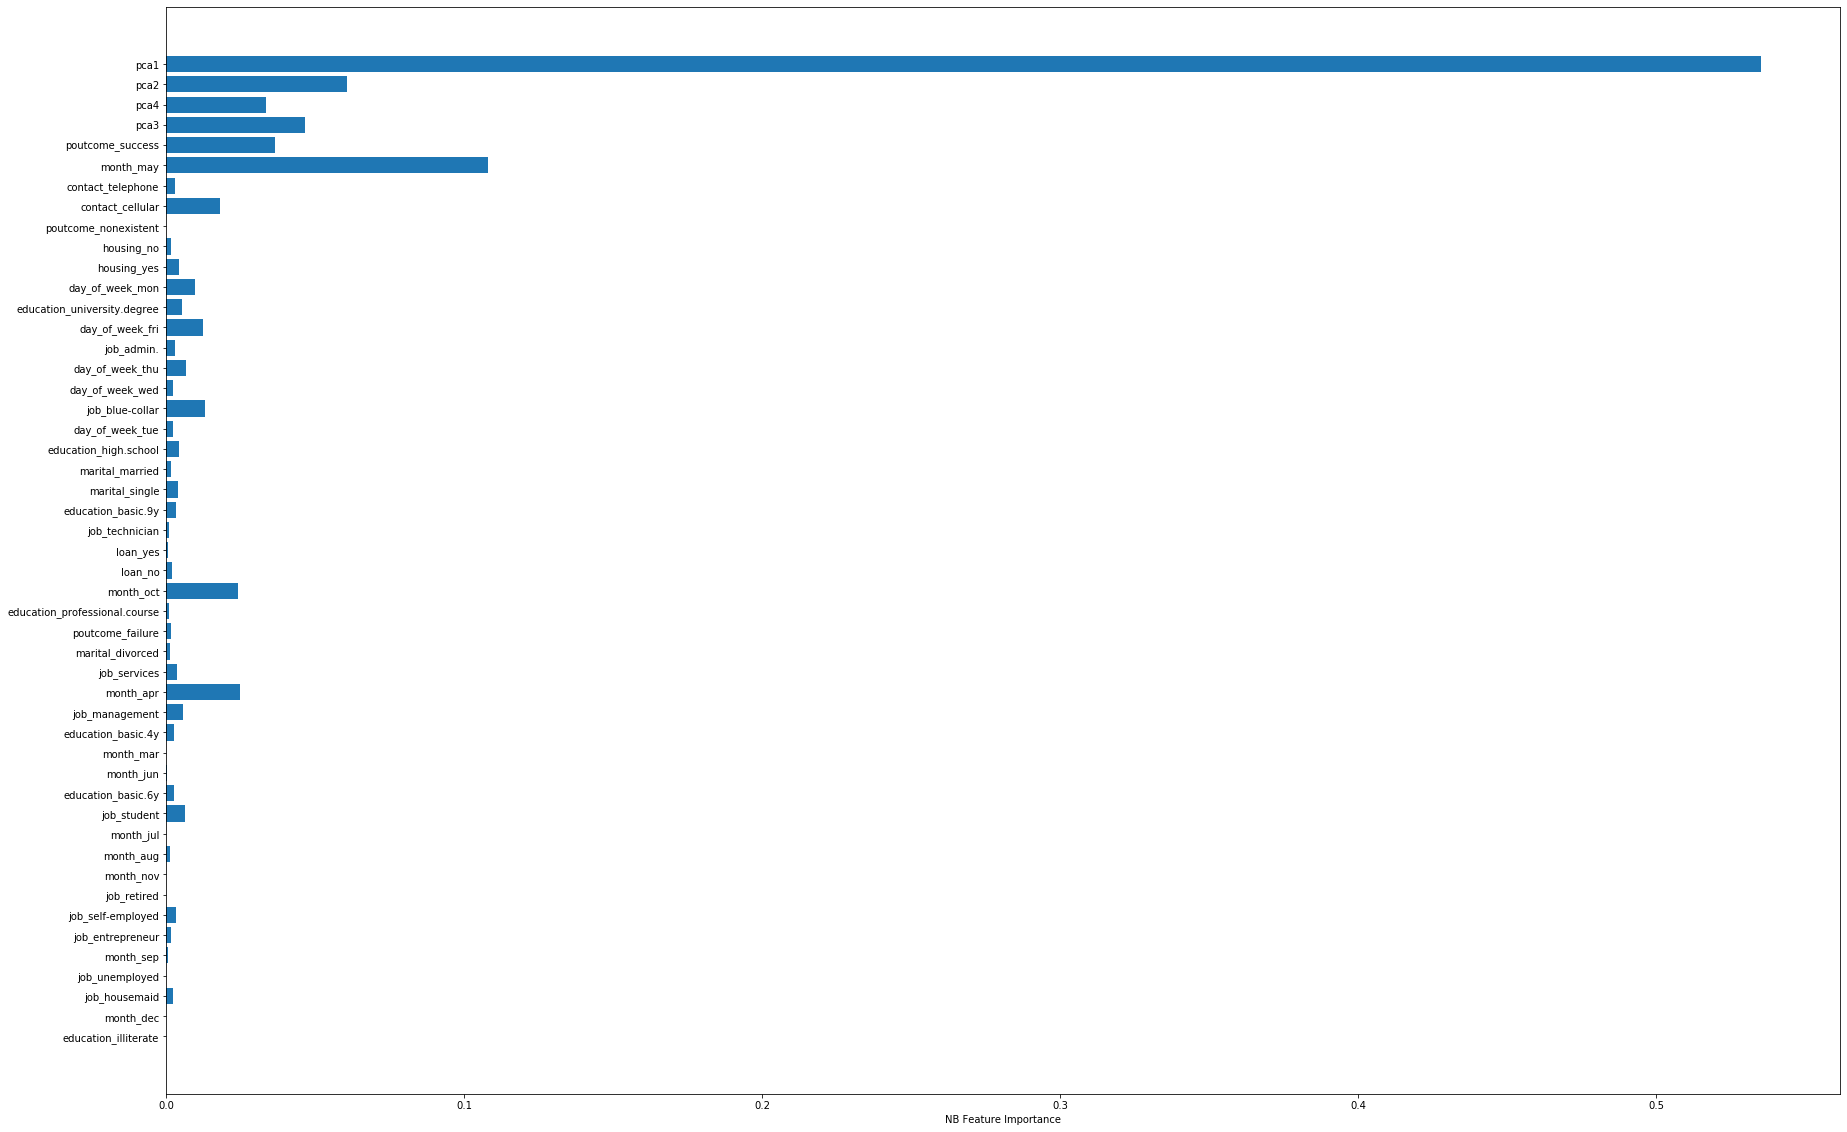

In [87]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_rf[1].feature_importances_.argsort()
plt.figure(figsize = (30,20))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_dt[1].feature_importances_[sorted_idx])
plt.xlabel("NB Feature Importance")
plt.show()

#### XGB

In [90]:
pipeline_modelo_xgb = Pipeline([('preprocess', pipeline_completo),
                            ('xgb', xgb_best)])
pipeline_modelo_xgb.fit(X_t, y_train)

/home/sseppi/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x7f3fb19d2c10>),
                                                                  ('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  ['age', 'campaign',
                                                   'previous', 'euribor3m',
                                                   'cons.conf.idx',
                                                   'nr.employed',
                                                   'emp.var.rate',
     

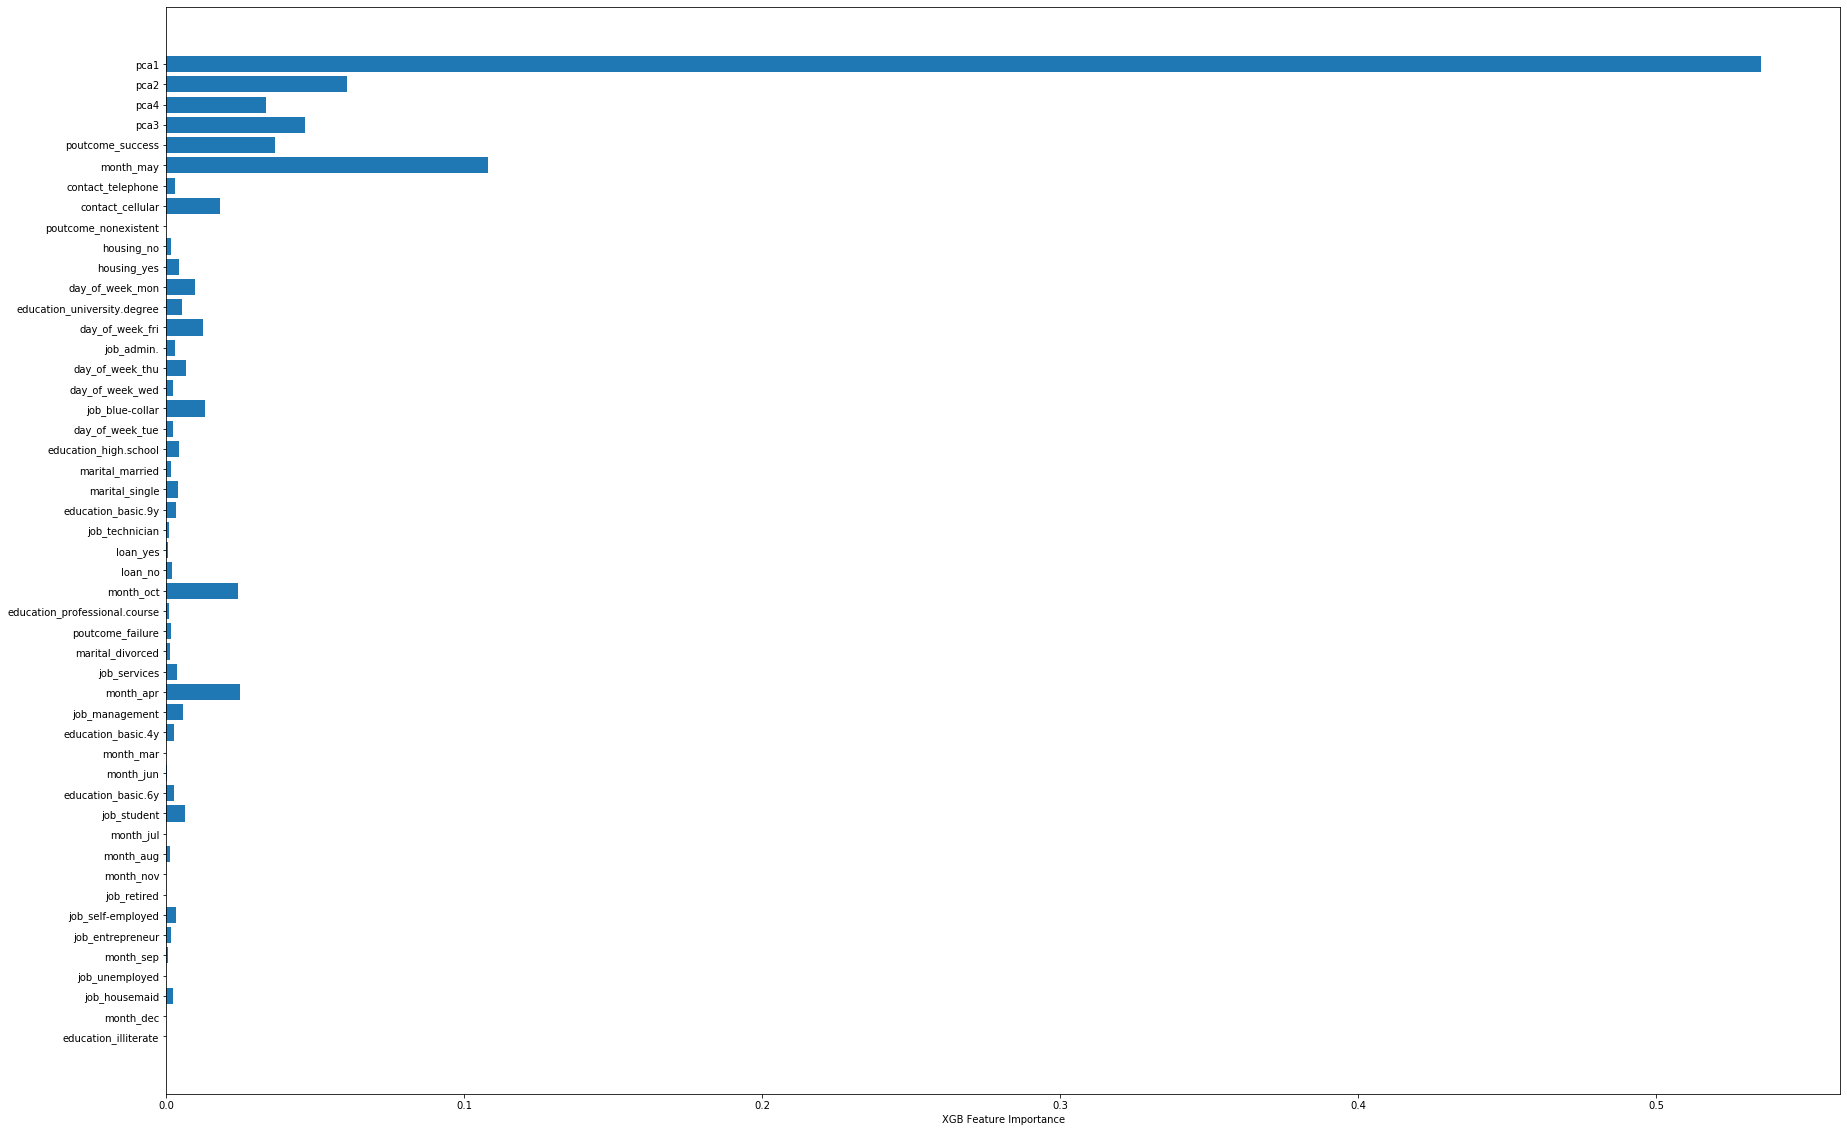

In [91]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_rf[1].feature_importances_.argsort()
plt.figure(figsize = (30,20))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_dt[1].feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")
plt.show()

#### Graficar las variables originales que tuvieron más peso en el PCA: Esto es para ver qué variables tienen más influencia en la conformación de cada PCA. Se muestran las 4 más importantes, pero podrían graficarse todas modificando el código

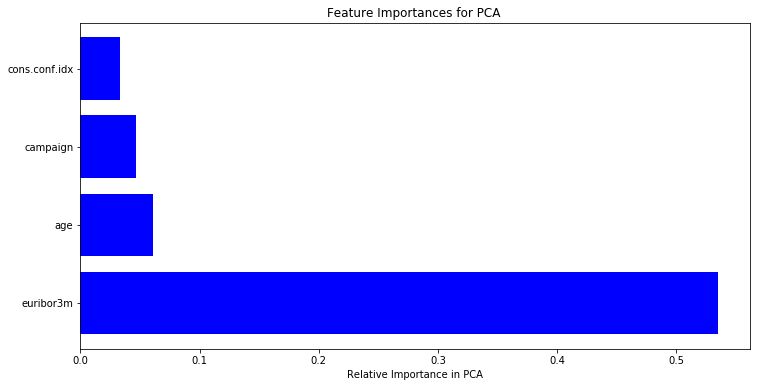

In [95]:
pca = pipeline_completo.transformers_[0][1][2]

n_pcs= pca.components_.shape[0]
initial_feature_names = X_t[variables_numericas].columns
most_important = [np.abs(pca.components_[i]).argmax() for i in     range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipeline_modelo_dt[1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:5]
top_importances = importances[:5]
plt.figure(figsize=(12,6))
plt.title('Feature Importances for PCA ')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance in PCA')
plt.show()

## **Aportes - Comentarios Leo**

#### XGBOOST

In [12]:
#Aplicamos las transformaciones previas a los conjuntos de Train y Validation

#variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome','month', 'day_of_week']
#variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx','nr.employed','emp.var.rate','cons.price.idx']

#Para la mejor combinación de variables
variables_categoricas = ['job', 'education', 'contact','loan', 'day_of_week', 'poutcome']
variables_numericas = ['age', 'campaign','previous', 'cons.conf.idx', 'euribor3m']


# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]     

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                           # ('standard_scaler', StandardScaler()), #Solamente activamos esta línea cuando el clasificador requiere escalado de variables numéricas (SVM, SGD)
                           # ('pca', PCA(n_components=4))   #En los casos que usemos las componentes principales en lugar de las variables numéricas
                             ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                #  ('imputer', SimpleImputer(strategy='most_frequent', missing_values='unknown')),     #Activamos en el caso que quisieramos imputar la categoría desconocido
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])


train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [13]:
#Entrenamiento de la mejor versión encontrada del modelo
xgb_best = xgb.XGBClassifier(seed=0, alpha= 7, learning_rate= 0.1, max_depth= 8, n_estimators=10, objective='binary:hinge')
xgb_best.fit(train, y_train)

C:\Users\usuario\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(alpha=7, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=0, reg_alpha=7,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, xgb_best.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xgb_best.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     22715
           1       0.47      0.56      0.51      2945

    accuracy                           0.88     25660
   macro avg       0.71      0.74      0.72     25660
weighted avg       0.89      0.88      0.88     25660

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5679
           1       0.47      0.53      0.50       736

    accuracy                           0.88      6415
   macro avg       0.70      0.73      0.71      6415
weighted avg       0.88      0.88      0.88      6415



In [15]:
## Análisis en conjunto de test
X_test_ = X_test[variables_categoricas + variables_numericas] 
test = pipeline_completo.fit_transform(X_test_)
print("MÉTRICAS CONJUNTO DE TEST")
print(classification_report(y_test, xgb_best.predict(test)))

MÉTRICAS CONJUNTO DE TEST
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      7099
           1       0.44      0.53      0.48       920

    accuracy                           0.87      8019
   macro avg       0.69      0.72      0.70      8019
weighted avg       0.88      0.87      0.87      8019



In [47]:
#Computamos el ROC_AUC para Test

print(f' ROC_AUC para datos de Train: {roc_auc_score(y_train, xgb_best.predict(train))}')
print(f' ROC_AUC para datos de Val: {roc_auc_score(y_val, xgb_best.predict(val))}')
print(f' ROC_AUC para datos de Test: {roc_auc_score(y_test, xgb_best.predict(test))}')

 ROC_AUC para datos de Train: 0.7459556241864664
 ROC_AUC para datos de Val: 0.7427901086765123
 ROC_AUC para datos de Test: 0.7219738542476896


El mejor modelo encontrado para predecir si un cliente contrataría o no un PF fue el presentado en esta últmina instancia. 

Por medio de este, obtuvimos en el conjunto de test las siguientes métricas:

- Precisión del 94% en la clase 0 y 44% en la clase 1, indica que el modelo es capaz de identificar de manera correcta al 94% de los clientes que no contratarían un PF y al 44% de los clientes que sí lo contratarían. En promedio, entonces, clasifica de manera correcta al 69% de los clientes.
- Recall de 91% en la clase 0 y 53% en la clase 1, indica que el modelo logra captar de manera correcta al 91% de los clientes que no contratarían PF y al 53% de los que si lo contratarían. En promedio, logra captar adecauadamente al 72% de los clientes. 
- Dado que el interés está en ambos aspectos, por medio de f1 tenemos un promedio armónico de ambas que nos permitió comparar los modelos. En términos de esta, se alcanzó un valor de 0.93 en el grupo de clientes que no contrata PF y un valor de 0.48 entre el grupo de clientes que si lo contrata. En promedio, presenta un valor de 0.70. 
- Valores de ROC_AUC score muy parecidos entre entrenamiento, validación y test, y bastante por encima de 0.50, que corresponde a un modelo totalmente aleatorio. Esto quiere decir que además de ser buenos valores, al ser similares entre sí nos aseguramos de que no se haya producido _overfitting_


**Feature explainability**

In [17]:
pipeline_modelo_xgb = Pipeline([('preprocess', pipeline_completo),
                            ('xgb', xgb_best)])
pipeline_modelo_xgb.fit(X_t, y_train)

C:\Users\usuario\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x00000098F5149FA0>)]),
                                                  ['age', 'campaign',
                                                   'previous', 'cons.conf.idx',
                                                   'euribor3m']),
                                                 ('cat',
                                                  Pipeline(steps=[('select_categoric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x00000098F5379190>),
                                                                  (...
                               importance_type='gain',
                               interaction_constraints=

In [18]:
# Si realizamos one hot encoding, vamos a tener el problema de que se incrementan el numero de features y necesitamos la nueva lista.
numeric_features = variables_numericas
cat_features = pipeline_modelo_xgb.named_steps['preprocess'].transformers_[1][1][1].get_feature_names(variables_categoricas)

In [19]:
onehot_columns = np.array(cat_features)
numeric_features_list = np.array(numeric_features)
numeric_features_list = np.append(numeric_features_list, onehot_columns)

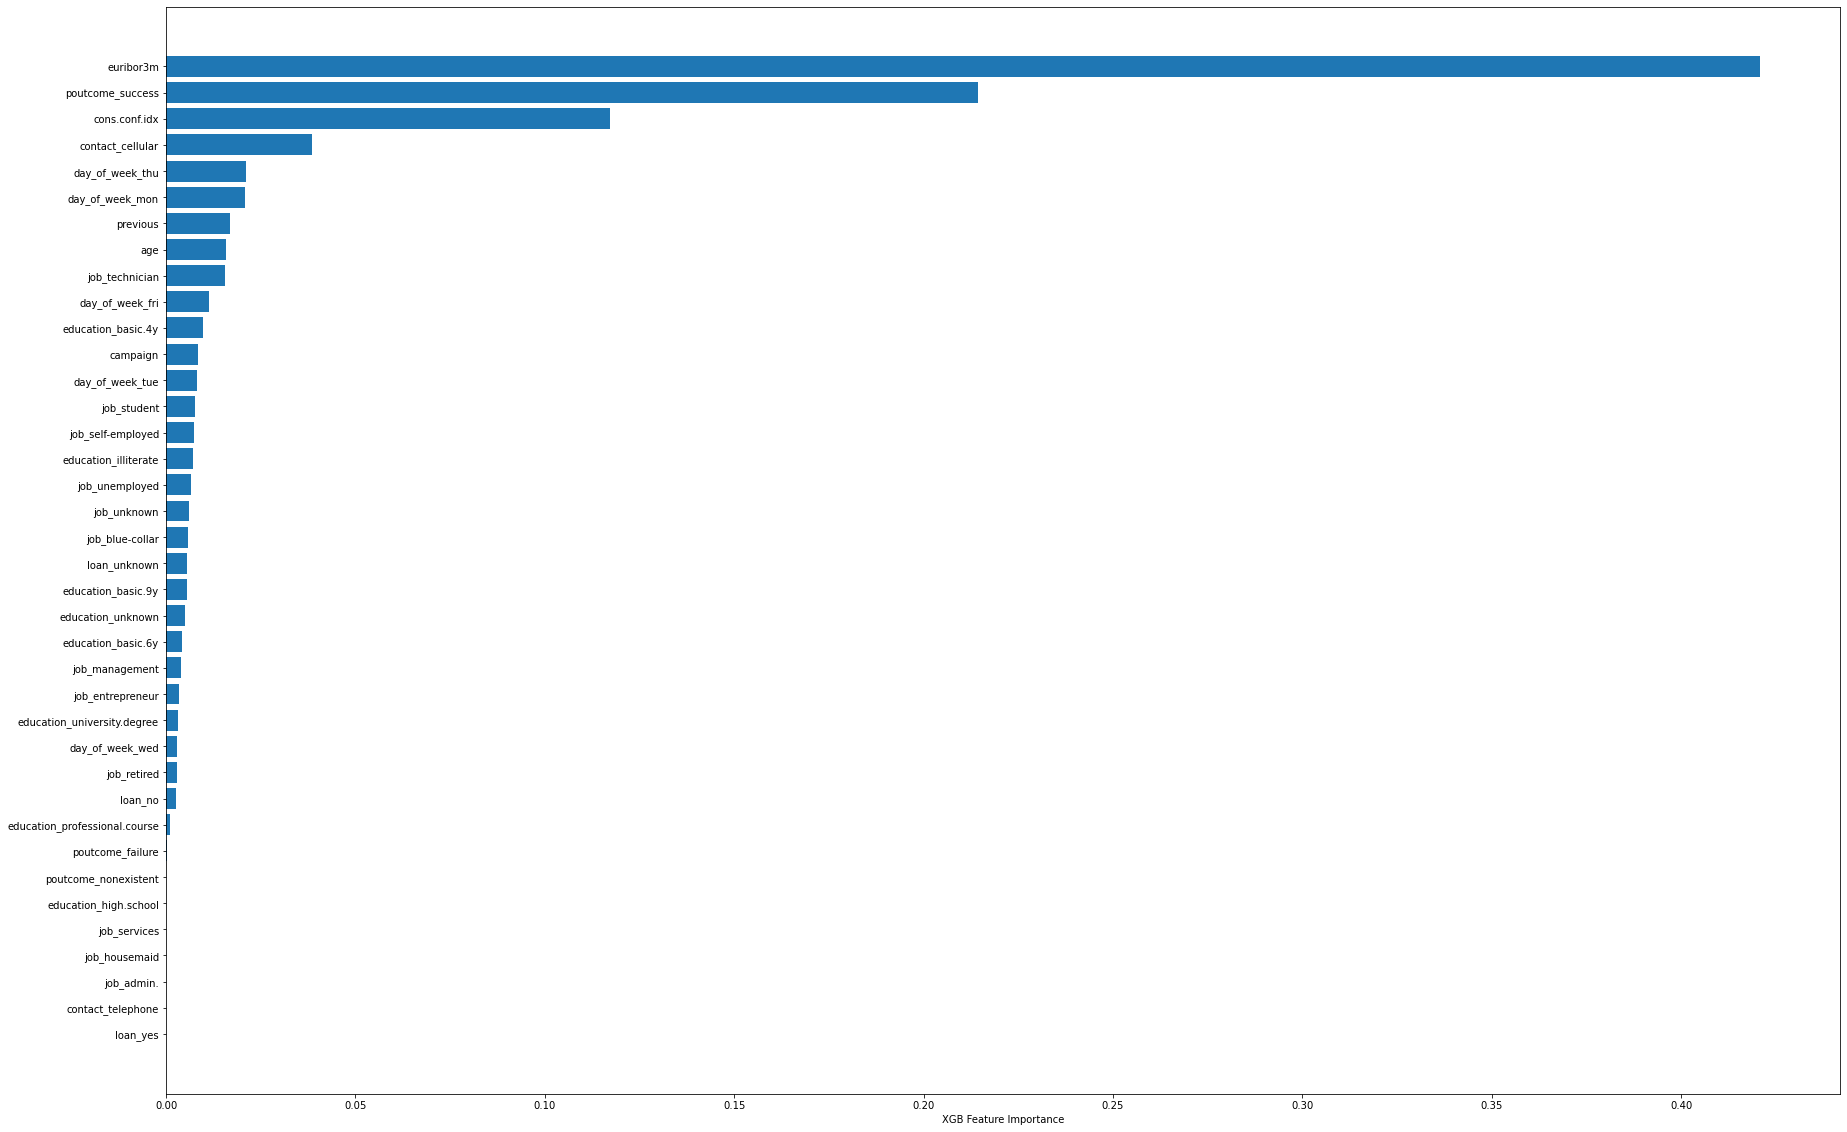

In [20]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_xgb[1].feature_importances_.argsort()
plt.figure(figsize = (30,20))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_xgb[1].feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")
plt.show()

El análisis de la importancia de las variables que explican el modelo permite  llegar a las siguientes conclusiones:

- La variable que tiene mayor relevancia es la tasa de interés, lo cual era de esperar ya que el rendimiento de la inversión es un aspecto clave a considerar para decidir si contratar o no un PF.
- En segunda instancia, la variable que indica si el cliente contrató un PF luego de campañas de marketing previas. En este caso, el resultado también resulta razonable ya que se espera exista algún vínculo o reincidencia en la conducta de contratación de PF en personas que ya están al tanto de este tipo de instrumentos y los han contratado previamente.
- En tercera instancia, el índice de confianza del consumidor resulta un predictor importante para la contratación del PF, lo cual probablemente tenga que ver que en contextos de mayor certidumbre o confianza sobre las condiciones macroeconómicas, los clientes sean más propensos a contratar PF.
- Si los clientes que fueron contactados por celular, y si fueron contactados los días jueves y lunes, también resultan tener cierta importancia para predecir la contratación del PF. En estos casos, la justificación no es tan clara. 
- En el orden siguiente, la cantidad de veces que fueron contactados anteriormente y la edad también presentan cierta relevancia para explicar la contratación del PF.
